# Unsupervised pixel-wise segmentation using autoencoder model

This work presents using 1-d convolutional autoencoder model to perform pixel clustering based on raman spectroscopy values.

Things to try: <br>
1. bottleneck size <br>
2. different clustering method <br>


## 1. Data Preprocessing

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

with h5py.File('MOSAIC_Slices_8 9 10 11 12 13 _PROCESS_same.h5', 'r') as f:
    base_items = list(f.items())
    G1 = f.get('/BCARSImage').get("/BCARSImage/Z97 to 105_58").get("Z97 to 105_58_z13_SubDark_MergeNRBs_Anscombe_SVD_InvAnscombe_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG_SubtractROI")
    G1_items = np.array(G1)

with h5py.File('MOSAIC_HCMV01_2018925_15_18_27_40030_PROCESS_2018925_16_29_5_508729_(3)_PROCESS_2019122_2_0_59_82982_December_2019.h5', 'r') as f:
    base_items = list(f.items())
    G2 = f.get('/BCARSImage').get('/BCARSImage/AlgaeI_3_5ms_Pos_0_11').get('AlgaeI_3_5ms_Pos_0_11_z16-19_SubDark_Anscombe_SVD_InvAnscombe_MergeNRBs_KK_PhaseErrorCorrectALS_ScaleErrorCorrectSG_Continue_SubtractROI')
    G2_items = np.array(G2)
    print(G2_items.shape)

(420, 556, 1600)
(344, 392, 1600)


In [39]:
import pickle
with open('image2data.pkl', 'wb') as f:
    pickle.dump(images_G1, f)

In [37]:
data_G1 = (G1_items['Re']**2+G1_items['Im']**2)**0.5
data_G2 = (G2_items['Re']**2+G2_items['Im']**2)**0.5

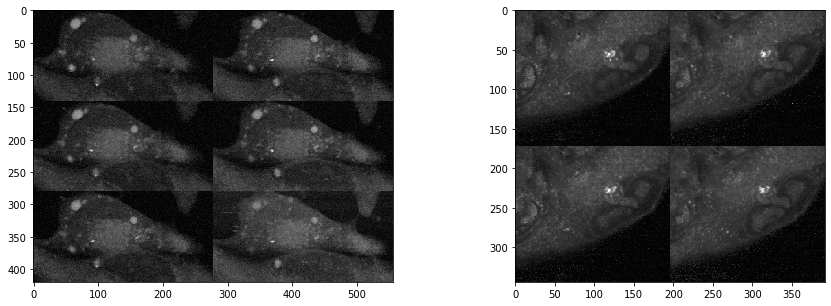

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(data_G1[:,:,1100], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(data_G2[:,:,1500], cmap='gray')
plt.show()

In [29]:
def crop_image2(data, N_H, N_W):

    images = []
    H, W, C = data.shape
    mid_H = H//N_H
    mid_W = W//N_W
    images.append(data[:mid_H, :mid_W, :])
    images.append(data[mid_H:, :mid_W, :])
    images.append(data[:mid_H, mid_W:, :])
    images.append(data[mid_H:, mid_W:, :])

    return images

def crop_image3(data, N_H, N_W):

    images = []
    H, W, C = data.shape
    mid_H = H//N_H
    mid_W = W//N_W
    images.append(data[:mid_H, :mid_W, :])
    images.append(data[mid_H:2*mid_H, :mid_W, :])
    images.append(data[2*mid_H:, :mid_W, :])
    images.append(data[:mid_H, mid_W:, :])
    images.append(data[mid_H:2*mid_H, mid_W:, :])
    images.append(data[2*mid_H:, mid_W:, :])

    return images

images_G1 = crop_image3(data_G1, 3, 2)
images_G2 = crop_image2(data_G2, 2, 2)

In [5]:
# Take the first N image
N = 3

images = np.stack(images_G2[:N])

x_train = images.reshape(np.prod(images.shape[:3]), -1)[:,:,np.newaxis]
x_test = images_G2[3].reshape(np.prod(images_G2[3].shape[:2]), -1)[:,:,np.newaxis]

In [7]:
# Take the first image
data_G1 = images_G1[0].reshape(np.prod(images_G1[0].shape[:2]), -1)

N = len(data_G1)
train_size = int(np.floor(0.8*N))
indices = np.random.permutation(N)

x_train = data_G1[indices[:train_size], :][:,:,np.newaxis]
x_test = data_G1[indices[train_size:], :][:,:,np.newaxis]

## 2. Autoencoder Structure
### We will start to build 1-d convolutional autoencoder structure

In [8]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [5]:
import keras
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model, load_model
import h5py

x_input = Input(shape=(1600, 1))
x = Conv1D(16, 3, activation="relu", padding="same")(x_input)
x = MaxPool1D(2, padding="same")(x)
x = Conv1D(8, 3, activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
x = MaxPool1D(2, padding="same")(x)
x = Conv1D(1, 3, activation="relu", padding="same")(x)
#x = BatchNormalization()(x)
encoded = MaxPool1D(2, padding="same")(x)

encoder = Model(x_input, encoded)

x = Conv1D(1, 3, activation="relu", padding="same")(encoded)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
x = Conv1D(8, 2, activation='relu', padding="same")(x)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding="same")(x)
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
autoencoder = Model(x_input, decoded)
autoencoder.summary()

#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')


# decoded_stocks = autoencoder.predict(x_test)


Using TensorFlow backend.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1600, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1600, 16)          64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 800, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 800, 8)            392       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 400, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 1)            25        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 1)            0   

In [6]:
autoencoder = load_model('model.h5')

## 3. Training and testing
### 1) Mean square error

In [33]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 31136 samples, validate on 7784 samples
Epoch 1/20
31136/31136 [==============================] - 17s 557us/step - loss: 0.2280 - val_loss: 0.2162
Epoch 2/20
31136/31136 [==============================] - 16s 516us/step - loss: 0.2060 - val_loss: 0.1952
Epoch 3/20
31136/31136 [==============================] - 16s 523us/step - loss: 0.1859 - val_loss: 0.1761
Epoch 4/20
31136/31136 [==============================] - 16s 525us/step - loss: 0.1676 - val_loss: 0.1587
Epoch 5/20
31136/31136 [==============================] - 16s 522us/step - loss: 0.1509 - val_loss: 0.1427
Epoch 6/20
31136/31136 [==============================] - 16s 525us/step - loss: 0.1356 - val_loss: 0.1281
Epoch 7/20
31136/31136 [==============================] - 16s 520us/step - loss: 0.1216 - val_loss: 0.1148
Epoch 8/20
31136/31136 [==============================] - 16s 522us/step - loss: 0.1089 - val_loss: 0.1027
Epoch 9/20
31136/31136 [==============================] - 16s 525us/step - loss: 0.0974 - val_l

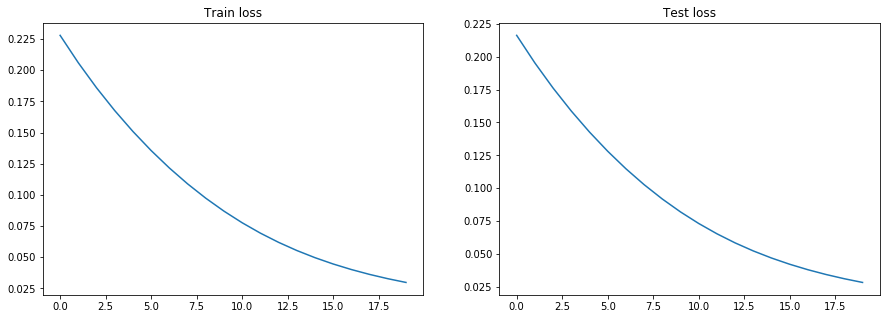

In [34]:
plot_history(history)

In [37]:
feature_extractor = Model(autoencoder.input, autoencoder.get_layer('max_pooling1d_6').output)
features = feature_extractor.predict(data_G1[:,:,np.newaxis])
features = features.squeeze(-1)

0.6442167
0.66075647
0.6501651
0.57539254
0.56488186
0.5225899


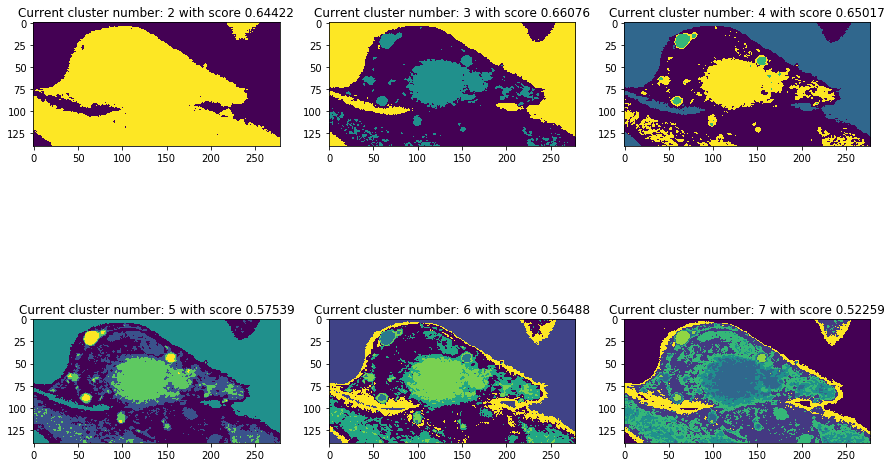

Maximum is number 3, the score is 0.6607564687728882


In [38]:
scores = []
labels_l = []
for i in range(2, 8):

    kmeans_model = KMeans(n_clusters=i, random_state=1).fit(features)
    labels = kmeans_model.labels_

    image_labels = labels.reshape(images_G1[0].shape[0], images_G1[0].shape[1])
    scores_s = metrics.silhouette_score(features, labels, metric='euclidean')
    scores_c = metrics.calinski_harabasz_score(features, labels)
    scores.append(scores_s)
    labels_l.append(image_labels)
    print(scores_s)

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title('Current cluster number: {} with score {:.5f}'.format(i+2, scores[i]))
    plt.imshow(labels_l[i])
plt.show()

print("Maximum is number {}, the score is {}".format(np.argmax(scores)+2, np.max(scores)))

### 2) Binary Cross Entropy Loss

In [10]:
# Train with single image
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 31136 samples, validate on 7784 samples
Epoch 1/20
31136/31136 [==============================] - 18s 582us/step - loss: 0.6302 - val_loss: 0.5284
Epoch 2/20
31136/31136 [==============================] - 17s 534us/step - loss: 0.3598 - val_loss: 0.1557
Epoch 3/20
31136/31136 [==============================] - 16s 530us/step - loss: 0.0894 - val_loss: 0.0689
Epoch 4/20
31136/31136 [==============================] - 17s 539us/step - loss: 0.0654 - val_loss: 0.0608
Epoch 5/20
31136/31136 [==============================] - 17s 538us/step - loss: 0.0579 - val_loss: 0.0543
Epoch 6/20
31136/31136 [==============================] - 17s 542us/step - loss: 0.0528 - val_loss: 0.0509
Epoch 7/20
31136/31136 [==============================] - 17s 536us/step - loss: 0.0504 - val_loss: 0.0494
Epoch 8/20
31136/31136 [==============================] - 17s 530us/step - loss: 0.0493 - val_loss: 0.0486
Epoch 9/20
31136/31136 [==============================] - 17s 533us/step - loss: 0.0487 - val_l

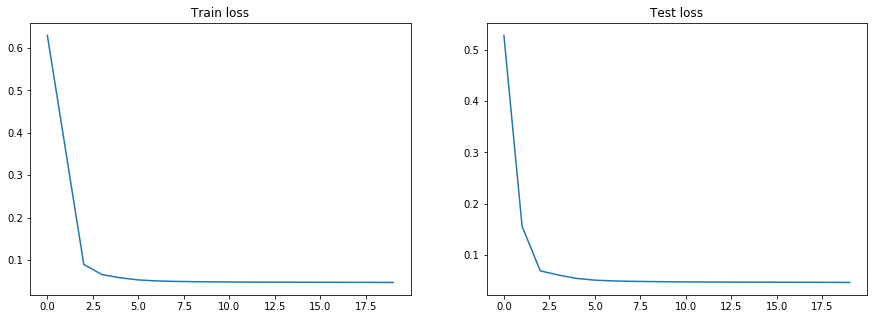

In [11]:
plot_history(history)
autoencoder.save('model_2.h5')

In [13]:
feature_extractor = Model(autoencoder.input, autoencoder.get_layer('max_pooling1d_3').output)
features = feature_extractor.predict(data_G1[:,:,np.newaxis])
features = features.squeeze(-1)

## 4. Clustering
### 1) TSNE Non-linear dimensionality reduction

In [10]:
from sklearn.manifold import TSNE
import time
start = time.time()
X_embedded = TSNE(n_components=2).fit_transform(features)
print(X_embedded.shape)
print("Elapsed time: ", time.time()-start)

(33712, 2)
Elapsed time:  1178.6588649749756


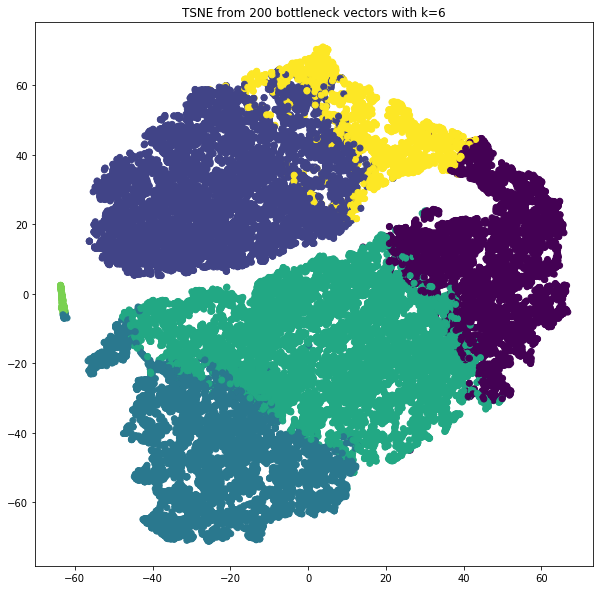

In [11]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(features)
labels = kmeans_model.labels_

plt.figure(figsize=(10,10))
plt.title("TSNE from 200 bottleneck vectors with k=6")
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
plt.savefig('./graph/tsne.jpg')
plt.show()

### 2) K-means clustering on extracted features

0.71006155
0.4927938
0.4817042
0.41994727
0.36090198
0.33251804


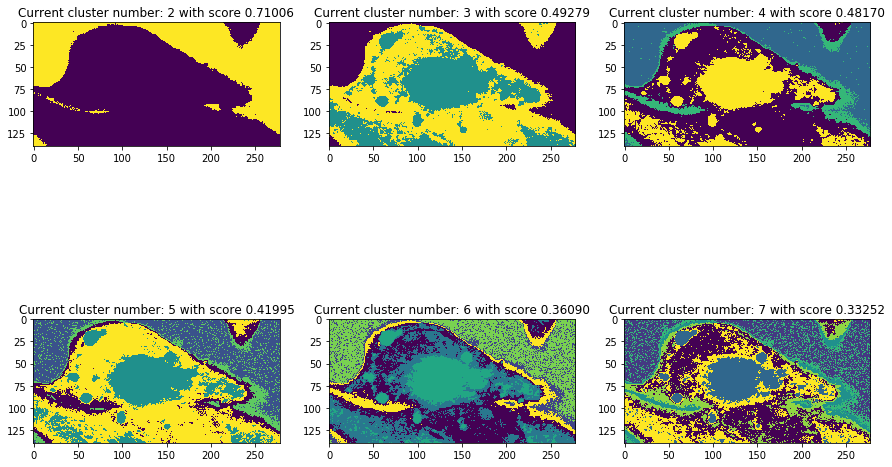

Maximum is number 2, the score is 0.7100615501403809


In [15]:
scores = []
labels_l = []
for i in range(2, 8):

    kmeans_model = KMeans(n_clusters=i, random_state=1).fit(features)
    labels = kmeans_model.labels_

    image_labels = labels.reshape(images_G1[0].shape[0], images_G1[0].shape[1])
    scores_s = metrics.silhouette_score(features, labels, metric='euclidean')
    scores_c = metrics.calinski_harabasz_score(features, labels)
    scores.append(scores_s)
    labels_l.append(image_labels)
    print(scores_s)

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title('Current cluster number: {} with score {:.5f}'.format(i+2, scores[i]))
    plt.imshow(labels_l[i])

plt.savefig('./graph/kmeans_2.jpg')
plt.show()

print("Maximum is number {}, the score is {}".format(np.argmax(scores)+2, np.max(scores)))

### 3) Visualize single cluster

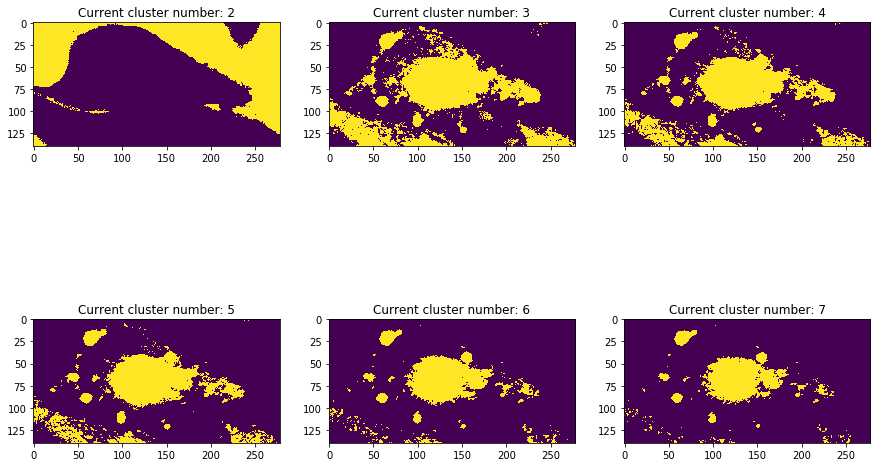

In [31]:
classes = [1,1,3,2,3,2]

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title('Current cluster number: {}'.format(i+2))
    img = labels_l[i].copy()
    img[img!=classes[i]] = 0
    plt.imshow(img)
plt.savefig('./graph/one-cluster_2.jpg')
plt.show()


### Saving results

In [31]:
for i in range(6):
    print(images_G1[i].reshape(np.prod(images_G1[i].shape[:2]), -1).shape)

(38920, 1600)
(38920, 1600)
(38920, 1600)
(38920, 1600)
(38920, 1600)
(38920, 1600)


Current image 0


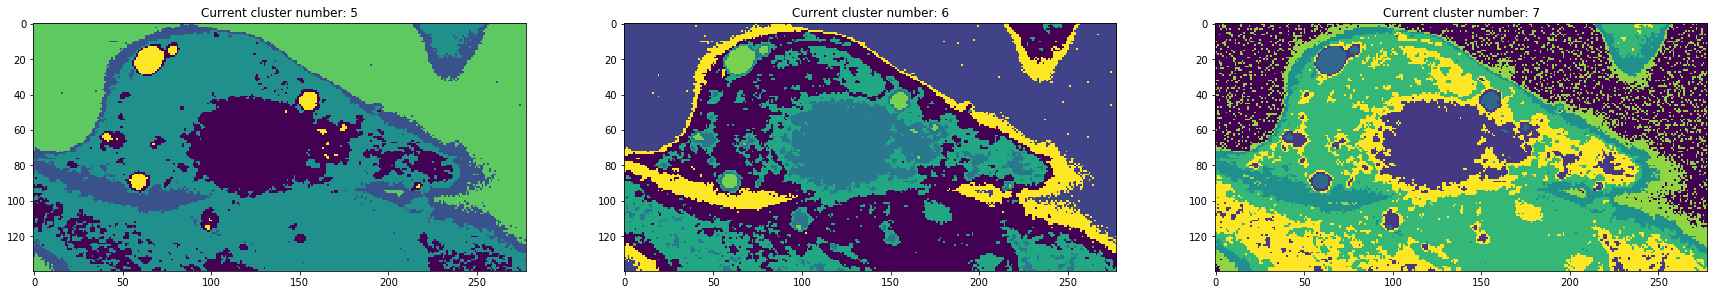

Current image 1


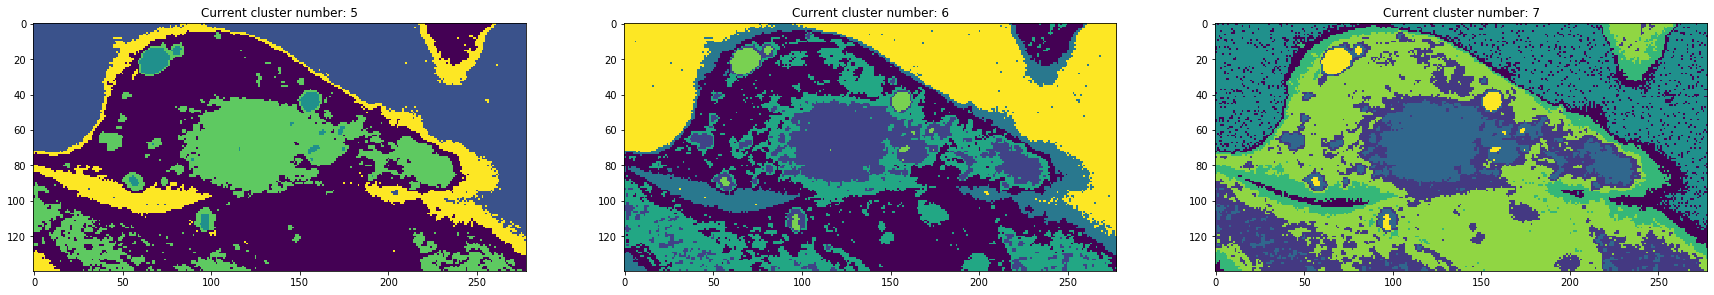

Current image 2


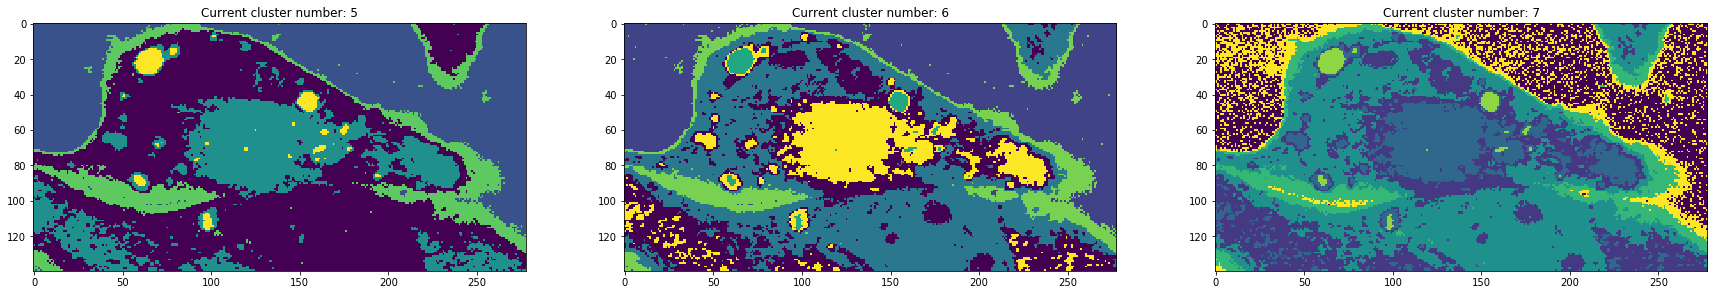

Current image 3


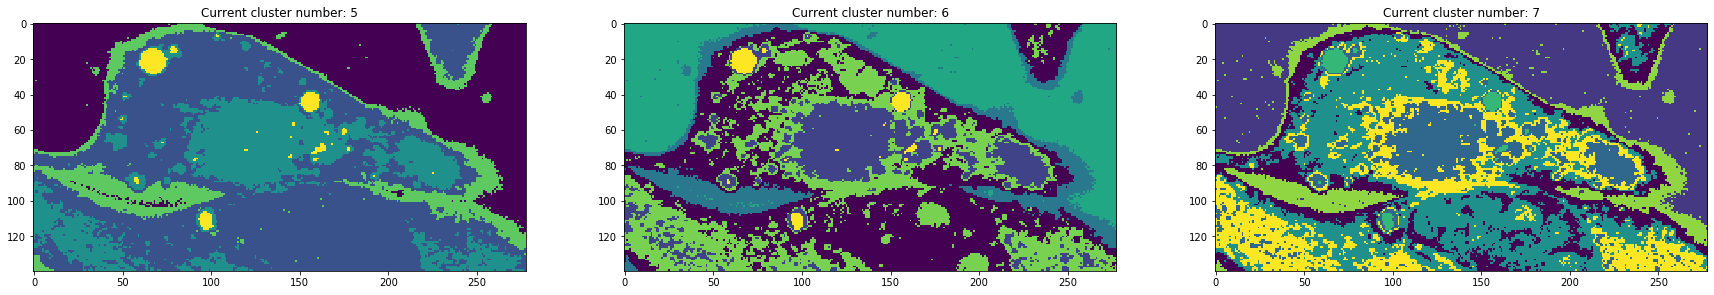

Current image 4


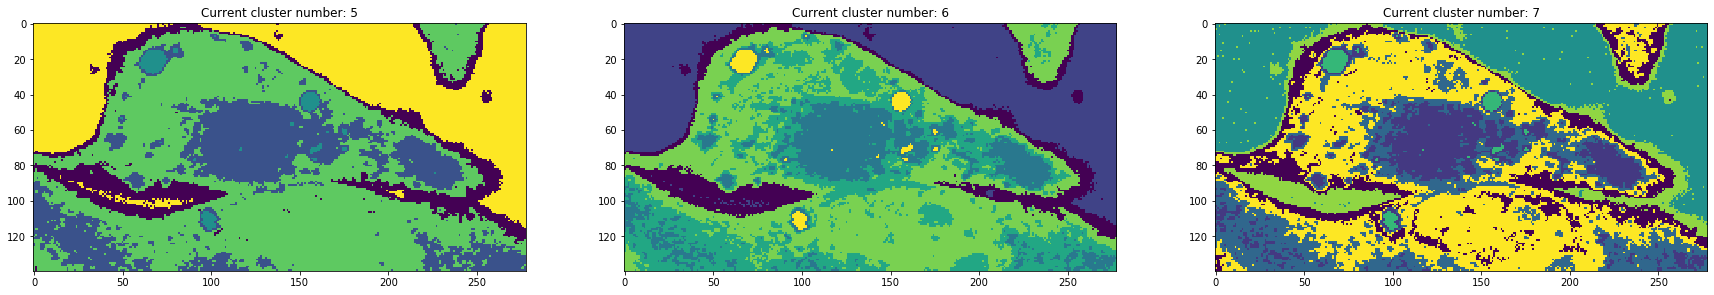

Current image 5


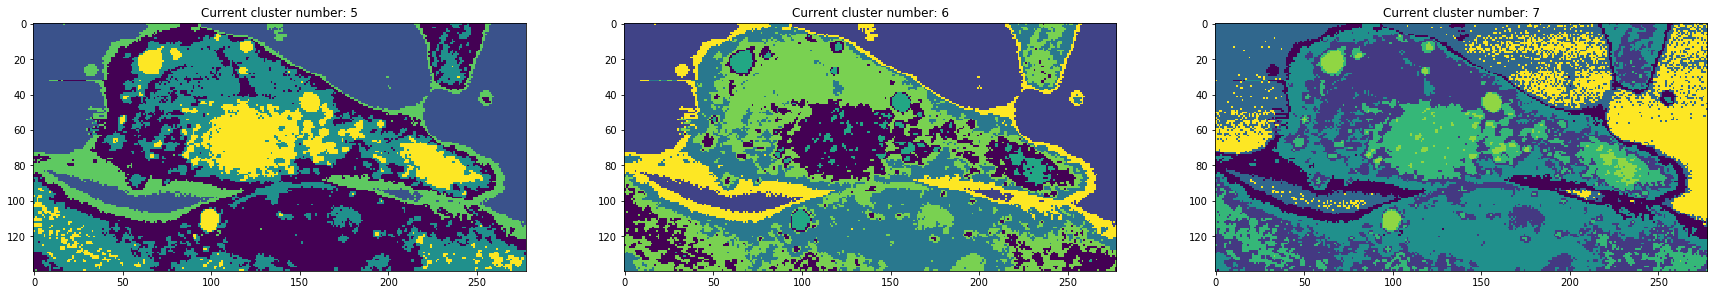

In [32]:
feature_extractor = Model(autoencoder.input, autoencoder.get_layer('max_pooling1d_6').output)
all_labels = np.zeros((6, 3, 140, 278))

for i in range(6):
    print("Current image", i)
    data_G1 = images_G1[i].reshape(np.prod(images_G1[i].shape[:2]), -1)
    features = feature_extractor.predict(data_G1[:,:,np.newaxis])
    features = features.squeeze(-1)
    
    for j in range(5, 8):

        kmeans_model = KMeans(n_clusters=j, random_state=1).fit(features)
        labels = kmeans_model.labels_

        image_labels = labels.reshape(images_G1[0].shape[0], images_G1[0].shape[1])
        
        all_labels[i,j-5,:,:] = image_labels
        

    plt.figure(figsize=(30,10))
    for j in range(3):
        plt.subplot(1,3,j+1)
        plt.title('Current cluster number: {}'.format(j+5))
        plt.imshow(all_labels[i,j,:,:])
    plt.savefig('./graph/results-kmeans/image2-{}.jpg'.format(i))
    plt.show()

In [33]:
import pickle
with open('graph/results-kmeans/image2.pkl', 'wb') as f:
    pickle.dump(all_labels, f)

### 4) Spectral Clustering algorithms

In [ ]:
from sklearn.cluster import OPTICS
import time

start = time.time()
clustering = OPTICS(eps=1, min_samples=2, cluster_method='dbscan').fit(features)
labels = clustering.labels_

image_labels = labels.reshape(images_G2[0].shape[0], images_G2[0].shape[1])
print("Elaspe time: ", time.time()-start)